**1. Mengunduh dataset dari Kaggle**

(Khusus jika dijalankan dengan Google Colab) Sebelum menjalankan perintah di bawah, pastikan API token `kaggle.json` anda telah diunggah ke folder `content` di Google Colab.

Jika ingin dijalankan di local computer, tidak perlu menjalankan perintah di bawah. Dataset dapat diunduh secara manual dari [Aerial Cactus Identification](https://www.kaggle.com/c/aerial-cactus-identification/data) di Kaggle.


**2. Mengimpor *library* yang diperlukan**

Setidaknya untuk pemodelan ini diperlukan *library* `PIL`, `zipfile`, `os`, `pandas`, `matplotlib`, `sklearn`, dan yang paling utama yaitu torch dan `torchvision`.



In [2]:
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [3]:
#Untuk mengatasi cuda runtime error (59), jalankan ini.
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

**3. Mempersiapkan data**

Dataset yang telah diunduh kemudian dibuka, dibedah isinya menggunakan EDA sederhana, lalu untuk dataset dari `train.zip` dipisah *label*-nya menjadi dataset untuk pelatihan dan validasi menggunakan `sklearn` dengan rasio 4:1. Selanjutnya seluruh dataset yang awalnya berupa gambar diubah menjadi tensor, diselaraskan dengan setiap label yang tepat, kemudian dipersiapkan menggunakan `DataLoader` dengan tiap-tiap datanya dikelompokkan menjadi beberapa *batch* dengan ukuran tertentu. 

In [9]:
cwd = os.getcwd()

train_zip = cwd+'/aerial-cactus-identification/train.zip'
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall(cwd+'/aerial-cactus-identification/kaggle/')

test_zip = cwd+'/aerial-cactus-identification/test.zip'
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall(cwd+'/aerial-cactus-identification/kaggle/')
    
for dirname, _, filenames in os.walk(cwd+'/aerial-cactus-identification/kaggle/'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/test\000940378805c44108d287872b2f04ce.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/test\0017242f54ececa4512b4d7937d1e21e.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/test\001ee6d8564003107853118ab87df407.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/test\002e175c3c1e060769475f52182583d0.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/test\0036e44a7e8f7218e9bc7bf8137e4943.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/train\0004be2cfeaba1c0361d39e2b000257b.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/train\000c8a36845c0208e833c79c1bffedd1.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/train\000d1e9a533f62e55c289303b072733d.jpg
d:\Kaggle Stuff\Aerial Cactus/aerial-cactus-identification/kaggle/train\0011485b40695e9138e92d0b3fb55128.jpg
d:\Kaggle Stuff\Aerial C

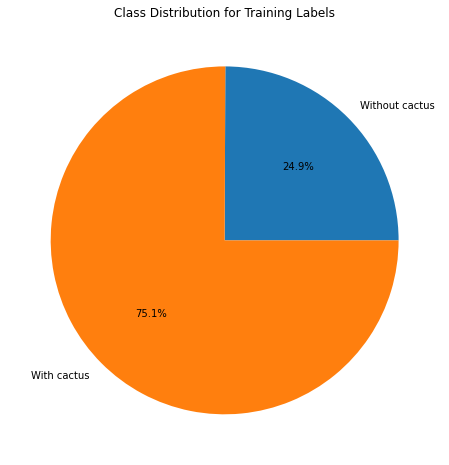

In [12]:
train_label = pd.read_csv(cwd+'/aerial-cactus-identification/train.csv')

label = 'Without cactus', 'With cactus'
plt.figure(figsize = (8,8))
plt.title('Сlass Distribution for Training Labels')
plt.pie(train_label.groupby('has_cactus').size(), labels = label, autopct='%1.1f%%')
plt.show()

In [13]:
train_label.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [14]:
test_label = pd.read_csv(cwd+'/aerial-cactus-identification/sample_submission.csv')
test_label.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [15]:
training_path = cwd+'/aerial-cactus-identification/kaggle/train'
test_path = cwd+'/aerial-cactus-identification/kaggle/test'

In [16]:
training_label, validation_label = train_test_split(train_label, 
                                test_size=0.2,
                                stratify=train_label['has_cactus'],
                                random_state=10)

In [17]:
train_size = len(training_label)
valid_size = len(validation_label)
test_size = len(os.listdir(test_path))

print('There are {} many images in all folders'.format(len(os.listdir(training_path))+test_size))
print('There are {} many images to train with'.format(train_size))
print('There are {} many images to do validation testing with'.format(valid_size))
print('There are {} many images to test with'.format(test_size))

There are 21500 many images in all folders
There are 14000 many images to train with
There are 3500 many images to do validation testing with
There are 4000 many images to test with


In [18]:
class CactusDataset(Dataset):
    def __init__(self,labels,folder,transform=None):
        super().__init__()
        self.labels=labels.values
        self.folder=folder
        self.transform=transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__ (self,index):
        image_name,label=self.labels[index]
        image_path=os.path.join(self.folder,image_name)
        image=PIL.Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image=self.transform(image)
        return image,label

In [19]:
batch_size = 512
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = CactusDataset(labels=training_label, folder=training_path, transform=transform)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
valid_dataset = CactusDataset(labels=validation_label, folder=training_path, transform=transform)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle=True, num_workers=0)
test_dataset = CactusDataset(labels=test_label, folder=test_path, transform=transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

**4. Perancangan arsitektur *convolutional neural network* (CNN) serta penentuan metode optimisasi dan *loss function***

Untuk kasus ini, digunakan *convolutional neural network* dengan empat kali konvolusi. Metode optimisasi yang digunakan adalah *Adam* dengan *learning rate* $0.001$ dan *loss function* yang dipilih adalah *binary crossentropy*.

In [20]:
class SimpleCNN(nn.Module): 
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 512, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = (2, 2)) 
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [21]:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


Pelatihan dapat dibantu dengan GPU NVidia CUDA atau murni menggunakan CPU. Perintah berikut digunakan untuk mengaktivasi GPU supaya dapat mempercepat pelatihan.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cpu')

In [23]:
net = SimpleCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

**5. Pelatihan *neural network***

Perintah di bawah digunakan untuk melatih *neural network* yang telah dibentuk sebelumnya sebanyak $100$ kali pelatihan untuk mendapatkan bobot yang sesuai. Tetapi untuk berjaga-jaga, ditetapkan *early stopping* yang aktif ketika akurasi pelatihan dan akurasi validasi mencapai lebih dari $0.99$.

In [24]:
epochs = 100
print('Start training\n')
for epoch in range(epochs): 
    epoch_loss = 0.0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for images, labels in train_loader:
        optimizer.zero_grad()

        images = images.to(device)
        labels_amount = len(labels)
        labels = labels.float()
        labels = labels.resize_(labels_amount, 1)
        labels = labels.to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = outputs.shape[0]
        epoch_loss += loss.item()*batch_size/train_size
        for i in range(batch_size):
          if outputs[i][0].item()>=0.5:
            if labels[i][0].item()>=0.5:
              true_positive+=1
            else:
              false_positive+=1
          else:
            if labels[i][0].item()<0.5:
              true_negative+=1
            else:
              false_negative+=1

    with torch.no_grad():
        val_epoch_loss = 0.0
        val_true_positive = 0
        val_true_negative = 0
        val_false_positive = 0
        val_false_negative = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels_amount = len(labels)
            labels = labels.float()
            labels = labels.resize_(labels_amount, 1)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            batch_size = outputs.shape[0]
            val_epoch_loss += loss.item()*batch_size/valid_size
            for i in range(batch_size):
              if outputs[i][0].item()>=0.5:
                if labels[i][0].item()>=0.5:
                  val_true_positive+=1
                else:
                  val_false_positive+=1
              else:
                if labels[i][0].item()<0.5:
                  val_true_negative+=1
                else:
                  val_false_negative+=1


    accuracy = (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    f1 = 2*(recall * precision) / (recall + precision)

    val_accuracy = (val_true_positive+val_true_negative)/(val_true_positive+val_true_negative+val_false_positive+val_false_negative)
    val_precision = val_true_positive/(val_true_positive+val_false_positive)
    val_recall = val_true_positive/(val_true_positive+val_false_negative)
    val_f1 = 2*(val_recall * val_precision) / (val_recall + val_precision)

    print("Epoch {}/{}".format(epoch+1,epochs))
    print("[Training]   Loss     : {:0.4f}, Accuracy     : {:0.4f}, Precision     : {:0.4f}, Recall     : {:0.4f}, F1 Score     : {:0.4f}".format(epoch_loss,accuracy, precision,recall,f1))
    print("[Validation] Val Loss : {:0.4f}, Val Accuracy : {:0.4f}, Val Precision : {:0.4f}, Val Recall : {:0.4f}, Val F1 Score : {:0.4f}\n".format(val_epoch_loss, val_accuracy, val_precision,val_recall,val_f1))
    if accuracy >= 0.99:
      if val_accuracy >= 0.99:
        break
print('Finished training')

Start training

Epoch 1/100
[Training]   Loss     : 0.5514, Accuracy     : 0.7319, Precision     : 0.7504, Recall     : 0.9632, F1 Score     : 0.8436
[Validation] Val Loss : 0.4512, Val Accuracy : 0.7506, Val Precision : 0.7506, Val Recall : 1.0000, Val F1 Score : 0.8575

Epoch 2/100
[Training]   Loss     : 0.3227, Accuracy     : 0.8597, Precision     : 0.8502, Recall     : 0.9871, F1 Score     : 0.9135
[Validation] Val Loss : 0.3142, Val Accuracy : 0.8737, Val Precision : 0.9858, Val Recall : 0.8439, Val F1 Score : 0.9094

Epoch 3/100
[Training]   Loss     : 0.2011, Accuracy     : 0.9244, Precision     : 0.9439, Recall     : 0.9560, F1 Score     : 0.9499
[Validation] Val Loss : 0.1568, Val Accuracy : 0.9380, Val Precision : 0.9446, Val Recall : 0.9745, Val F1 Score : 0.9593

Epoch 4/100
[Training]   Loss     : 0.1679, Accuracy     : 0.9349, Precision     : 0.9532, Recall     : 0.9605, F1 Score     : 0.9568
[Validation] Val Loss : 0.1581, Val Accuracy : 0.9357, Val Precision : 0.9785, 

**6. Pengujian *neural network***

*Neural network* diuji dengan dataset dari `test.zip`, kemudian ditampilkan hasilnya untuk 8 gambar secara acak.

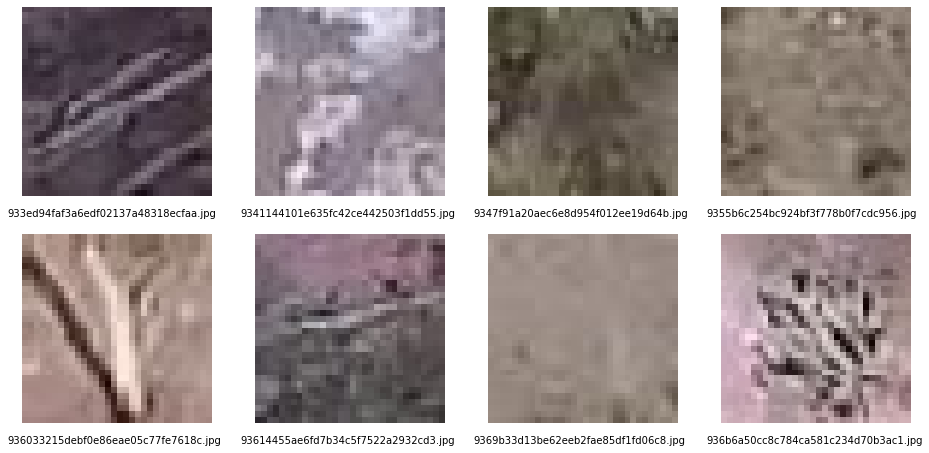

There's a cactus in 933ed94faf3a6edf02137a48318ecfaa.jpg
There's a cactus in 9341144101e635fc42ce442503f1dd55.jpg
There's no cactus in 9347f91a20aec6e8d954f012ee19d64b.jpg
There's no cactus in 9355b6c254bc924bf3f778b0f7cdc956.jpg
There's a cactus in 936033215debf0e86eae05c77fe7618c.jpg
There's a cactus in 93614455ae6fd7b34c5f7522a2932cd3.jpg
There's no cactus in 9369b33d13be62eeb2fae85df1fd06c8.jpg
There's a cactus in 936b6a50cc8c784ca581c234d70b3ac1.jpg


In [25]:
import random

nrows = 4
ncols = 4

pic_index = random.randint(0,test_size-1)

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_human_names = os.listdir(test_path)
train_human_names.sort()

next_human_pix = [os.path.join(test_path, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_human_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.text(-3, 35, train_human_names[i+pic_index-8])
plt.show()

with torch.no_grad():
  result = []
  for images, labels in test_loader:
    images = images.to(device)
    outputs = net(images)
    for i in range(outputs.shape[0]):
      result.append(outputs[i][0].item())
  
  for i in range(pic_index-8, pic_index):
    if result[i]>=0.5:
      print("There's a cactus in {}".format(test_label['id'][i]))
    else:
      print("There's no cactus in {}".format(test_label['id'][i]))